# Train the model

Now that we have the images ready, we will train the model and test using **fastAI** library. 

### About Fast AI library

If you haven't used fast AI library, there is an excellent course by *Jermy Howard* which teaches Deep Learning along with the library. It would be a good start even for engineers who are about to start their machine learning career. After completing the Deep Learning Specialisation from *Andew Ng*, I felt that I knew how stuff work and what I should do. But I was not confident enough to write the piece of code that actually works. Fast AI made my practise much simpler. I feel taking both courses is a great idea as one compliments the other. Jermy approaches the problem solving top down, where as Andrew Ng approached it bottom up.

### Getting started in training

Get Matlab to autoload the graph images instead of explicit *show()* methods and import libraries

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

Do the necessery imports

In [2]:
from fastai.conv_learner import *
from fastai.dataset import *

from pathlib import Path
import json
from PIL import ImageDraw, ImageFont,Image
from matplotlib import patches,patheffects
import pandas as pd

Set the locations where the data is available

In [300]:
IMAGE_FOLDER_NAME='stamped'
PATH=Path('./data/stamp-localisation')
IMAGE_PATH=PATH/IMAGE_FOLDER_NAME
IS_STAMPED_CSV=PATH/'is_stamped.csv'
BBOX_CSV=PATH/'bbox.csv'
BBOX_COMPLETE_CSV=PATH/'bbox_complete.csv'
COMPLETE_CSV=PATH/str(IMAGE_FOLDER_NAME+'.csv')

Get the complete CSV file as a dataframe

In [4]:
input_df = pd.read_csv(COMPLETE_CSV,header=None)

### Check for the stamp

As a first step, we can generate the CSV file from the actual *stamped.csv*  by taking only the first 2 columns of the CSV file. We'll use this for training our module to verify if the image has stamp or not, as the first step.

In [5]:
input_df.loc[:,0:1].to_csv(IS_STAMPED_CSV,header=False,index=False)

We take out the bounding box values of the files which has the stamps alone. We can use this in dataframe later.

In [6]:
bbox_df=input_df[input_df[1]==1][[0,2]]

We then save that to a CSV so as to use that file for the bounding box detection 

In [7]:
bbox_df.to_csv(BBOX_CSV,header=False,index=False)

Now we'll try to verify if we have set our file names , image paths and the bounding box appropriately

In [11]:
(IMAGE_PATH/bbox_df.iloc[1,0]).exists()

True

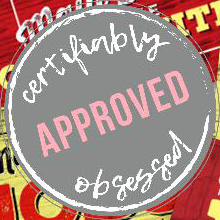

In [12]:
image_id=547
im2 = Image.open(str(IMAGE_PATH/bbox_df.iloc[image_id,0]))
coord_x1,coord_y1,coord_x2,coord_y2=map(int,bbox_df.iloc[image_id,1].split(' '))
im2.crop((coord_x1,coord_y1,coord_x2,coord_y2))

## Choosing the model and training

Here we are using Residual Networks with 34 layers for the classification. We will resize all the images to 224$*$224 image with the mini-batch size of 64.

In [13]:
f_model = resnet34
sz=224
bs=64
n=len(IS_STAMPED_CSV.open().readlines())-1

We are using the parameters that we initialised above. The library has augmentation features. That is, if we say that even if we flip left right, or top down, the output will not get affected, we can let the library augment the data so that it feeds more data to train the model and improve the accuracy.. Here, we say top down transformation is the same. 

we also say that the 20% of the total data set is for validation. Its optional to call out. But I was having issue in the library while running the program. Got to know that it was a temporary work around.

In [14]:
tfms = tfms_from_model(f_model,sz,aug_tfms=transforms_top_down)

md = ImageClassifierData.from_csv(PATH, IMAGE_FOLDER_NAME, IS_STAMPED_CSV,tfms=tfms, bs=bs,val_idxs=get_cv_idxs(n,val_pct=0.2))

We say accuracy as the metric to calculate and use *Adam Optimizer* to optimise the model and use the pretrained Resnet model

In [15]:
learn = ConvLearner.pretrained(f_model,md, metrics =[accuracy])
learn.opt_fn=optim.Adam

Learning Rate Finder is a useful tool to find the learning find the optimal Learning Rate

In [16]:
lrf = learn.lr_find()

 84%|████████▍ | 49/58 [00:25<00:04,  1.93it/s, loss=3.1] 

Using learning rate finder, we would be able to see the graph of **Learning Rate Vs Loss**. This helps to understand which learning rate can have a greater convergence to the minimum loss. Choose the one which has the slope declining very near to the minimum loss

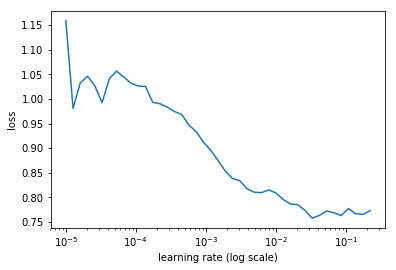

In [17]:
learn.sched.plot(n_skip=0)

Now seeing the plot we come to know that the optimal Learning rate is somewhere around $2e^-2$. So we use that as our learning rate. 

We unfreeze all layers and train the model for around 2 cycles with 2 loops per cycle

In [18]:
lr=2e-2
lrs=np.array([lr/9,lr/3,lr])

In [19]:
learn.fit(lrs,1,cycle_len=2,cycle_mult=2)

epoch      trn_loss   val_loss   accuracy   
    0      0.517086   0.350444   0.842162  
    1      0.407964   0.31973    0.873514  
    2      0.425306   0.377196   0.802162  
    3      0.392912   0.31123    0.868108  
    4      0.353      0.302929   0.887568  
    5      0.333859   0.287977   0.891892  
    6      0.318222   0.287398   0.884324  
    7      0.302577   0.281378   0.890811  


[array([0.28138]), 0.8908108103597486]

In [77]:
y_pred = learn.predict()
_,y_test = next(iter(md.val_dl))

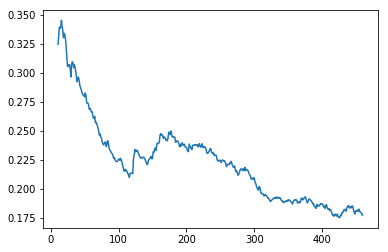

In [25]:
learn.sched.plot_loss()

Unfreeze the last 2 layers and train a bit more

In [20]:
learn.freeze_to(-2)

In [22]:
learn.fit(lrs,1,cycle_len=2,cycle_mult=2)

epoch      trn_loss   val_loss   accuracy   
    0      0.272507   0.163394   0.937297  
    1      0.226397   0.138017   0.955676  
    2      0.220523   0.163031   0.955676  
    3      0.219938   0.140757   0.953514  
    4      0.195301   0.13049    0.955676  
    5      0.184634   0.127127   0.957838  
    6      0.168678   0.12542    0.955676  
    7      0.168496   0.122848   0.956757  


[array([0.12285]), 0.9567567574655688]

Unfreeze all the layers and train more

In [455]:
learn.unfreeze()

In [24]:
learn.fit(lrs,2,cycle_len=2,cycle_mult=3)

epoch      trn_loss   val_loss   accuracy   
    0      0.269256   0.171216   0.940541  
    1      0.209705   0.1463     0.95027   
    2      0.248812   26.248205  0.793514  
    3      0.230835   0.155341   0.949189  
    4      0.216081   0.140836   0.958919  
    5      0.189112   0.1444     0.962162  
    6      0.186389   0.125208   0.958919  
    7      0.174917   0.126278   0.961081  


[array([0.12628]), 0.961081081789893]

**96%** seems to be great. We will save the model

In [26]:
learn.save('is_stamped_1_0')

In [80]:
learn.load('is_stamped_1_0')

### Localisation of the Stamp

Now that we have done the first part model of checking if stamp is available or not, we will build another model which can get the bounding boxes of the stamp

As a first step we will build a model that outputs the four bounding box coordinates. These outputs are real values, not a classification output like if the image has stamp or not. So we mention *continous=True* there.

In [27]:
n=len(bbox_df)

tfms = tfms_from_model(f_model,sz, crop_type=CropType.NO)
md = ImageClassifierData.from_csv(PATH,IMAGE_FOLDER_NAME,BBOX_CSV,tfms=tfms,continuous=True,bs=bs,val_idxs=get_cv_idxs(n,val_pct=0.2))

### Add Custom Header

Now we just do a quick check on how the CSV has the data

In [29]:
BBOX_CSV.open().readlines()[:2]

['9728879c-50d4-4760-9246-1a80804ff476.jpeg,13 61 233 281\n',
 'b2f5a5c2-c947-43d6-b8f2-58d173b780c5.jpeg,43 129 263 349\n']

We add one layer which takes in the output of Resnet 34 and converts it to the coordinates and use L1 Loss function to determine the loss

In [393]:
head_reg4 = nn.Sequential(Flatten(),nn.Linear(25088,4))
learn = ConvLearner.pretrained(f_model, md, custom_head=head_reg4)
learn.opt_fn = optim.Adam
learn.crit=nn.L1Loss()

Now we see how the model looks like layer by layer. Clearly, we can see that the Flattened layer is added at the tail end. I commented out, feel free to uncomment and run to check for once

In [31]:
# learn.summary()

As usual we try to find the best learning rate. I do run this cell multiple times after every fit method so that I use the optimum learning rate

In [413]:
learn.lr_find(1e-12)

 97%|█████████▋| 38/39 [00:31<00:00,  1.20it/s, loss=156] 

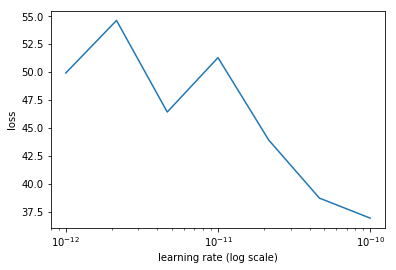

In [420]:
learn.sched.plot(n_skip=0,n_skip_end=30)

As per the graph, we chose $1*e^{-11}$ as an optimum learning rate and went ahead

In [415]:
lr = 1e-11

In [35]:
learn.fit(lr,2,cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   
    0      229.644829 219.530028
    1      190.003883 177.438575
    2      169.38541  173.471266


[array([173.47127])]

After we fit, we unfreeze the last 2 layers, rerun the test

In [36]:
learn.freeze_to(-2)

In [403]:
lrs = np.array([lr/9,lr/3,lr])

In [404]:
learn.fit(lrs,2,cycle_len=2, cycle_mult=3)

epoch      trn_loss   val_loss   
    0      34.2523    44.201266 
    1      34.625093  44.191224 
    2      33.934901  45.011553 
    3      33.894803  43.467278 
    4      33.87077   43.687111 
    5      33.911442  44.811229 
    6      33.290769  43.674176 
    7      34.763672  43.206201 


[array([43.2062])]

In [39]:
learn.save('bb_primitive_1_0')

In [470]:
learn.load('bb_primitive_1_0')

Unfreeze, run once more

In [399]:
learn.unfreeze()

In [421]:
lrs = np.array([lr/100,lr/10,lr])

In [ ]:
learn.fit(lrs,2,cycle_len=2, cycle_mult=3)

epoch      trn_loss   val_loss   
    0      34.93758   43.149994 
    1      33.738419  43.506382 
  0%|          | 0/39 [00:00<?, ?it/s]

Save and rerun the model

In [156]:
learn.save('bb_1')

In [448]:
learn.load('bb_1')

### Testing the model using the images in Training Set

Now we get a random image from the images that we used for training and run our test on it. The model must be able to atleast predict bounding boxes for these images with some level of accuracy

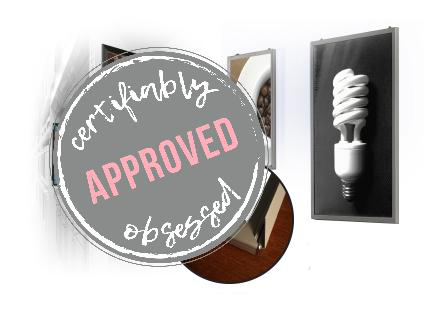

In [449]:
from random import randint
image_id=randint(0,len(bbox_df)-1)
image_url=IMAGE_PATH/bbox_df.iloc[image_id,0]
trn_tfms, val_tfms = tfms_from_model(f_model,sz)
im = val_tfms(open_image(str(image_url)))
pred = learn.predict_array(im[None])
image=Image.open(str(image_url))
image

(442, 316)
[[ 16.98529  56.65942 239.81061 280.1911 ]]


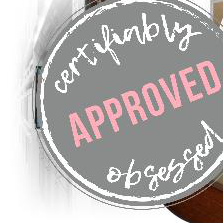

In [450]:
print(image.size)
print(pred)
# image
image.crop(pred[0][:4])

We see that it was able to predict the stamp pretty accurately.

### Create new example to test

Set all paths for the new test images

In [462]:
from random import randint
IMAGE_DIR_PATH=Path('./data/stamp-localisation/test-art-work')
GENERATED_IMAGE_PATH=list(IMAGE_DIR_PATH.iterdir())[randint(0,len(list(IMAGE_DIR_PATH.iterdir()))-1)]
STAMP_IMAGE_PATH=Path('./data/stamp-localisation/stamp-image.png')
GENERATED_OUTPUT_DIR_PATH=Path('./data/stamp-localisation/test')

We reuse the method that we used to generate the image expect for the fact that we will discard the coordinates instead of saving it in a CSV file

In [463]:
def save_synthesised_img(art_work_image):
    from random import randint
    import uuid
    (a_width,a_height)=art_work_image.size
    stamp_image = Image.open(STAMP_IMAGE_PATH).resize((200,200)).convert('RGBA')
    (n_width,n_height)=stamp_image.size
    is_resized=False
    if(n_height > a_height):
            (n_width,n_height)=(int(n_width*a_height/n_height),a_height)
            is_resized=True
    if(n_width > a_width):
            (n_width,n_height)=(a_width,(int(n_height*a_width/n_width)))
            is_resized=True
    if(is_resized):
        stamp_image= stamp_image.resize((n_width,n_height))
    coord_h1 =  randint(0,a_height-n_height)
    coord_w1 =  randint(0,a_width-n_width)
    art_work_img1=art_work_image.copy()
    art_work_img1.paste(stamp_image,(coord_w1,coord_h1),stamp_image)
    coors = '{} {} {} {}'.format(coord_w1,coord_h1,n_width+coord_w1,n_height+coord_h1)
    fn1=str(uuid.uuid4())+'.jpeg'
    art_work_img1.save(str(GENERATED_OUTPUT_DIR_PATH/fn1))

Now we pick a random image from the new set of downloaded art work images and generate stamps on it 

In [458]:
image=Image.open(GENERATED_IMAGE_PATH).convert('RGB')
save_synthesised_img(image)

## Using the model / Testing the Model on new images

Now we test the model with the new image we generated in the previous step and check if this works for us

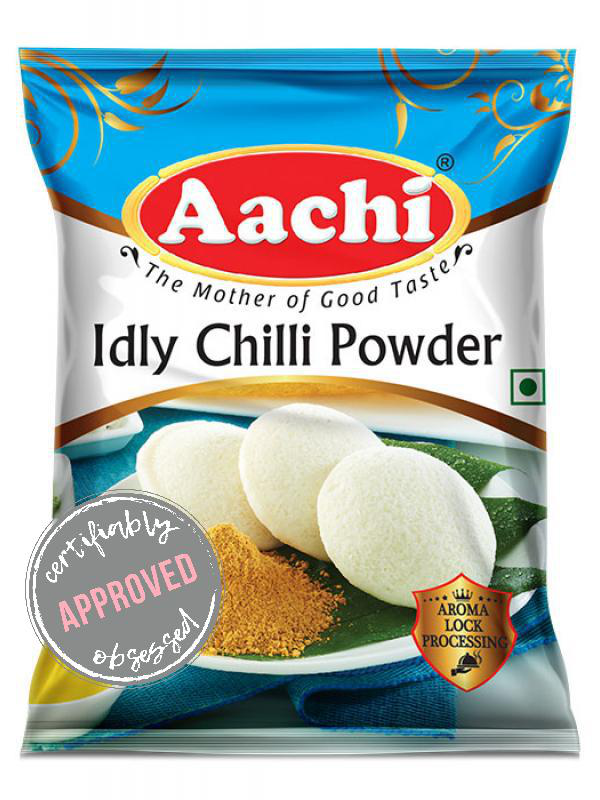

In [471]:
test_images=list(GENERATED_OUTPUT_DIR_PATH.iterdir())
image_id=randint(0,len(test_images)-1)
# image_id=len(test_images)-1
# image_url=OUTPUT_DIR_PATH/'a0a981a0-c12b-4b3d-8890-82d98bb4b64e.jpeg'
image_url=test_images[image_id]
trn_tfms, val_tfms = tfms_from_model(f_model,sz)
im = val_tfms(open_image(str(image_url)))
pred = learn.predict_array(im[None])
image=Image.open(str(image_url))
image

(600, 800)
[ 31.38932 462.5311  257.30185 681.6247 ]


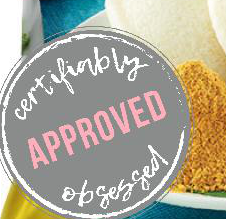

In [472]:
print(image.size)
print(pred[0])
# image
# image.crop((pred[0][:4]))
image.crop(pred[0][:4])
# print(pred[0][4])